## evaluate for Classification with sklearn

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
# augmentation
from albumentations.augmentations.transforms import Resize,Normalize
from albumentations import Compose

from dataset import load_train_data
from dataset import UkiyoeTestDataset
from dataset import UkiyoeTrainDataset
import models
import constants as cons
from convenient_function import fix_model_state_dict

In [23]:
train_images_path ='data'
train_labels_path ='data'
params_path ='params'

PARAM_LIST = [
    {'model':'/se_oversampling/senet154/fold0/with_pseudo_labeling/se_oversampling_best.pth','fix':False,'ratio':1},
    {'model':'/dense_oversampling/densenet161/fold0/with_pseudo_labeling/dense_oversampling_best.pth','fix':False,'ratio':1},
    {'model':'/seres_oversampling/se_resnet50/fold0/with_pseudo_labeling/seres_oversampling_best.pth','fix':False,'ratio':1},
    {'model':'/model_dense/densenet161/fold0/model_dense_880.pth','fix':False,'ratio':1},
    {'model':'/aug_decrease_effi_b3/efficientnet_b3/fold0/aug_decrease_effi_b3_790.pth','fix':True,'ratio':1},
    {'model':'/model_effi_b3/efficientnet_b3/fold0/model_effi_b3_980.pth','fix':True,'ratio':1},
    {'model':'/model_effi_b3_sampling/efficientnet_b3/fold0/with_pseudo_labeling/model_effi_b3_sampling_best.pth','fix':False,'ratio':2},
    {'model':'/model_senet154/senet154/fold0/model_senet154_680.pth','fix':True,'ratio':1},
    {'model':'/partical_augmentation/senet154/fold0/partical_augmentation_380.pth','fix':True,'ratio':1},
    {'model':'/se_oversampling/se_resnet50/fold0/se_oversampling_490.pth','fix':False,'ratio':2},
    {'model':'/ince3_w/inceptionv3/fold0/ince3_weight_670.pth','fix':False,'ratio':1}
]

In [3]:
def valid_loop(model, loader,data_len):
    model.eval()
    output = np.zeros((data_len,cons.NUM_CLASSES))
    label = np.zeros((data_len,cons.NUM_CLASSES))
    with torch.no_grad():
        for idx, feed in enumerate(tqdm(loader)):
            inputs, labels = feed
            inputs, labels = inputs.cuda(),labels.cuda()
            #forward
            outputs = torch.sigmoid(model(inputs))
            output[idx] = outputs.data.cpu().numpy()
            label[idx] = labels.data.cpu().numpy()
    return output,label

In [4]:
def confidence_check(pred,t,confidence,data_len):
    inference_ratio = np.sum(np.identity(cons.NUM_CLASSES)[pred],axis=0)
    t_ratio = np.sum(np.identity(cons.NUM_CLASSES)[t],axis=0)
    result = {}
        
    print('pred:\t',inference_ratio)
    print('t:\t',t_ratio)
    for label in range(cons.NUM_CLASSES):
        target_id = np.where(pred==label)[0]
        sorted_id = target_id[np.argsort(confidence[target_id][:,label])[::-1]]
        #print('label:',label)
        #print('\nconfidence_distribution:',np.sort(confidence[target_id][:,label])[::-1])
        # print('target_id:\t',target_id)
        # print('sorted_id:\t',sorted_id)

In [5]:
valid_loader = load_train_data(    
    train_images_path=train_images_path,
    train_labels_path=train_labels_path,
    batch_size=1,
    shuffle=False,
    valid=True,
    seed=98,
    transform=Compose([
        Resize(cons.IMAGE_SIZE,cons.IMAGE_SIZE),
        Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),max_pixel_value=255.0)]))


ratio_sum = 0
confidence_list=[]
for e in range(len(PARAM_LIST)):
    ratio_sum = ratio_sum + PARAM_LIST[e]['ratio']
    PARAM_PATH = params_path + PARAM_LIST[e]['model']
    model = models.get_model(model_name=PARAM_LIST[e]['model'].split('/')[2], num_classes=cons.NUM_CLASSES)
    if PARAM_LIST[e]['fix']:
        model.load_state_dict(fix_model_state_dict(torch.load(PARAM_PATH)))
    else:
        model.load_state_dict(torch.load(PARAM_PATH))
    confidence,label = valid_loop(model,valid_loader,631)
    confidence_list.append(confidence)
    #confidence_sum = confidence_sum + confidence*PARAM_LIST[e]['ratio']


100%|██████████| 631/631 [00:10<00:00, 57.43it/s]


In [24]:
confidence_sum = np.zeros((631,cons.NUM_CLASSES))
for e in range(len(PARAM_LIST)):
    confidence_sum = confidence_sum + confidence_list[e]*PARAM_LIST[e]['ratio']
pred = np.argmax(confidence_sum,axis=1)
t = np.argmax(label,axis=1)
confidence = confidence_sum/ratio_sum

acc = np.where(t==pred)[0].size/631
print(acc)
result = {}
result["confusion_matrix"]=confusion_matrix(t,pred)
result["precision_score"]=classification_report(t,pred)
print('- confusion matrix(x,t)\n',result["confusion_matrix"])
print('\n- precision score\n',result["precision_score"])

0.8938193343898574
- confusion matrix(x,t)
 [[117   2   0   0   0   0   0   1   1   0]
 [  3 124   1   2   2   0   1   1   0   0]
 [  0   1  55   0   2   0   3   0   3   0]
 [  0   2   0  36   2   0   1   3   1   0]
 [  0   2   2   0  66   1   1   0   0   0]
 [  0   2   1   0   3  28   0   0   0   0]
 [  0   1   2   0   0   0  73   0   1   0]
 [  1   2   0   6   1   0   0  14   0   0]
 [  0   0   0   0   3   0   2   0  28   0]
 [  2   0   0   0   1   1   0   0   0  23]]

- precision score
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       121
           1       0.91      0.93      0.92       134
           2       0.90      0.86      0.88        64
           3       0.82      0.80      0.81        45
           4       0.82      0.92      0.87        72
           5       0.93      0.82      0.87        34
           6       0.90      0.95      0.92        77
           7       0.74      0.58      0.65        24
           8      

In [7]:
confidence_check(pred,t,confidence,631)

pred:	 [123. 136.  61.  44.  80.  30.  81.  19.  34.  23.]
t:	 [121. 134.  64.  45.  72.  34.  77.  24.  33.  27.]


miss_images: [  1   2  48  49  50  62  93  96 102 109 124 128 137 157 159 160 161 167
 169 172 174 177 178 213 215 224 244 247 252 266 275 282 283 288 292 319
 327 329 331 338 340 353 356 360 374 380 383 427 433 437 441 444 452 466
 470 475 482 497 503 505 512 521 551 571 593 624 627]


[t: 0  ==> pred: 1 ]
ID: 160   confidence: 0.39752882432479125


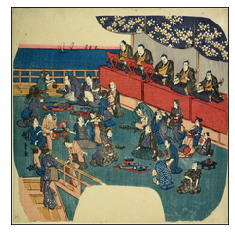

ID: 169   confidence: 0.5819948017597198


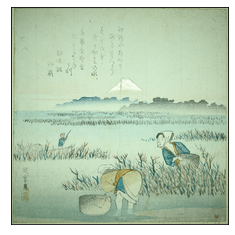

[t: 0  ==> pred: 7 ]
ID: 292   confidence: 0.48677303646288167


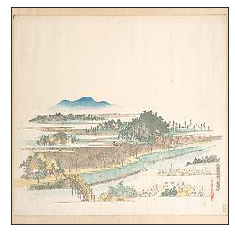

[t: 0  ==> pred: 8 ]
ID: 503   confidence: 0.6035689688645877


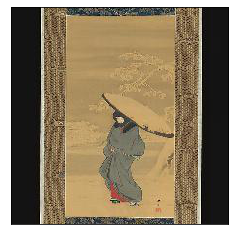

[t: 1  ==> pred: 0 ]
ID: 96   confidence: 0.4848357426145902


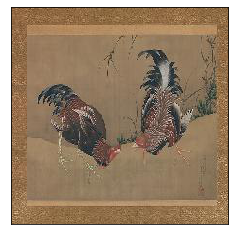

ID: 331   confidence: 0.5366679692211059


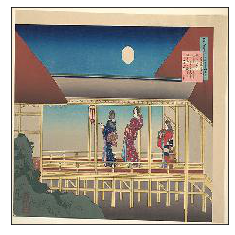

ID: 624   confidence: 0.6695860274709188


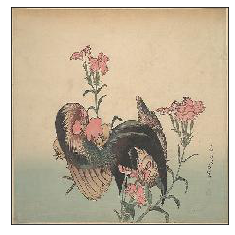

[t: 1  ==> pred: 2 ]
ID: 356   confidence: 0.3469193443441047


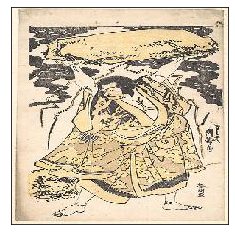

[t: 1  ==> pred: 3 ]
ID: 437   confidence: 0.6330761903753648


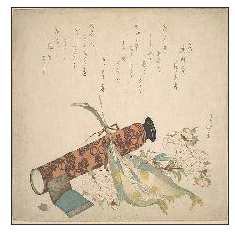

ID: 441   confidence: 0.33873011343754256


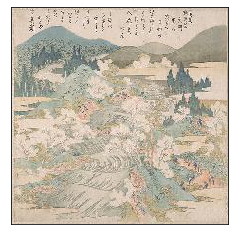

[t: 1  ==> pred: 4 ]
ID: 224   confidence: 0.33950520478762114


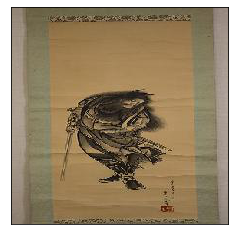

ID: 512   confidence: 0.7261242291558749


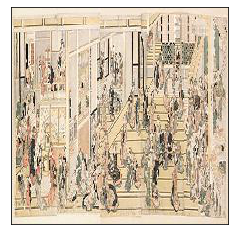

[t: 1  ==> pred: 6 ]
ID: 521   confidence: 0.6550418422915615


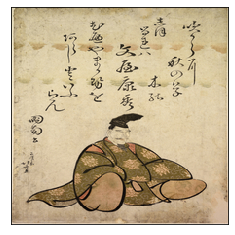

[t: 1  ==> pred: 7 ]
ID: 244   confidence: 0.39830854592415005


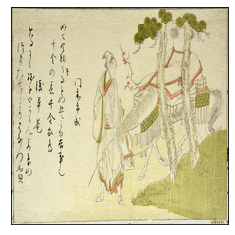

[t: 2  ==> pred: 1 ]
ID: 353   confidence: 0.28662581147196203


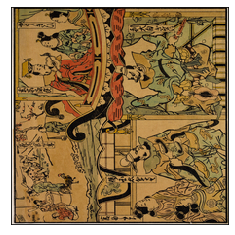

[t: 2  ==> pred: 4 ]
ID: 137   confidence: 0.3292780959119017


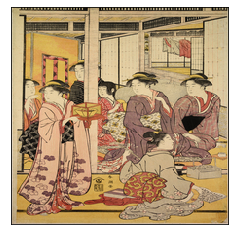

ID: 275   confidence: 0.590333876414941


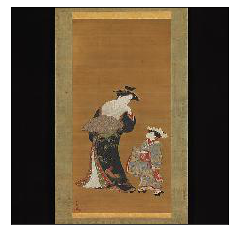

[t: 2  ==> pred: 6 ]
ID: 178   confidence: 0.33143984970565027


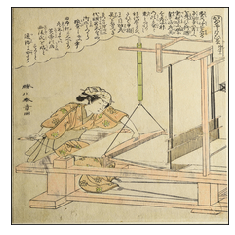

ID: 288   confidence: 0.35245865791176373


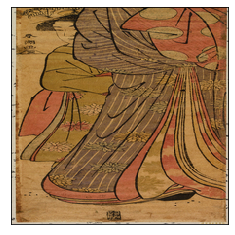

ID: 475   confidence: 0.7053564385725901


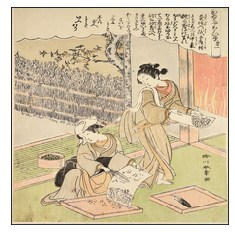

[t: 2  ==> pred: 8 ]
ID: 283   confidence: 0.8935709366431603


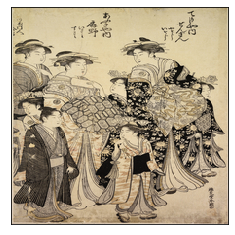

ID: 444   confidence: 0.32962225191295147


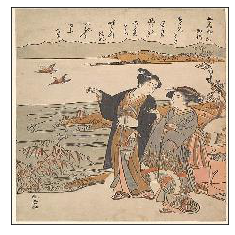

ID: 470   confidence: 0.6022112489892886


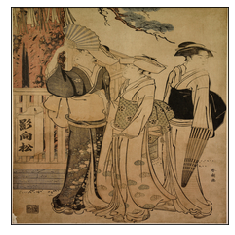

[t: 3  ==> pred: 1 ]
ID: 329   confidence: 0.5355382783768269


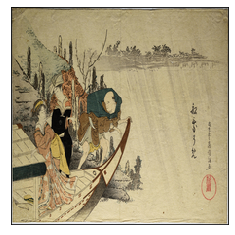

ID: 505   confidence: 0.4342224274833615


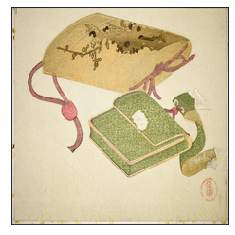

[t: 3  ==> pred: 4 ]
ID: 172   confidence: 0.4655138754930634


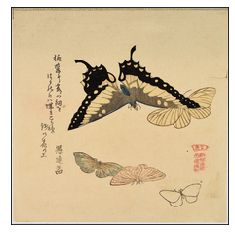

ID: 380   confidence: 0.39502375200390816


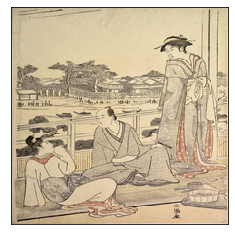

[t: 3  ==> pred: 6 ]
ID: 177   confidence: 0.30629945614446813


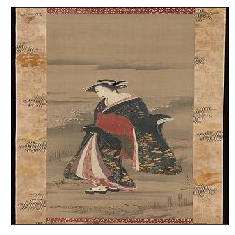

[t: 3  ==> pred: 7 ]
ID: 49   confidence: 0.5594872161746025


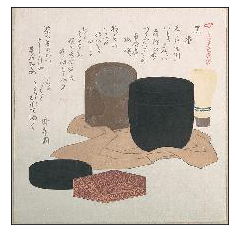

ID: 161   confidence: 0.5668256302356335


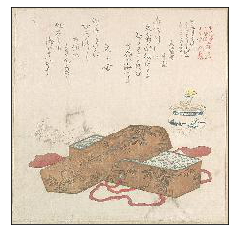

ID: 551   confidence: 0.7135990449728874


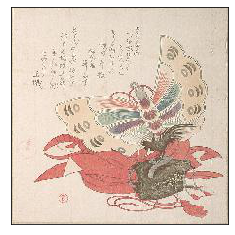

[t: 3  ==> pred: 8 ]
ID: 374   confidence: 0.43517949669442785


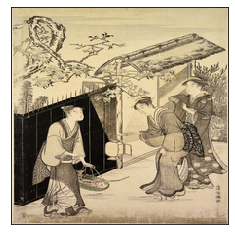

[t: 4  ==> pred: 1 ]
ID: 247   confidence: 0.5174687937475168


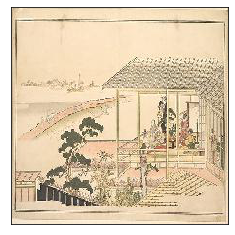

ID: 571   confidence: 0.6956270554891


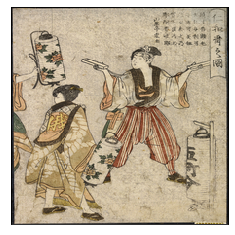

[t: 4  ==> pred: 2 ]
ID: 215   confidence: 0.6960214611429435


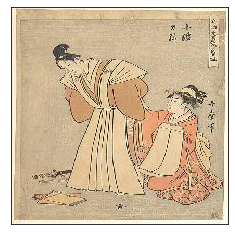

ID: 282   confidence: 0.4110819508249943


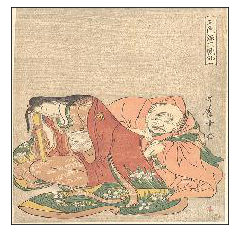

[t: 4  ==> pred: 5 ]
ID: 497   confidence: 0.5255791232562982


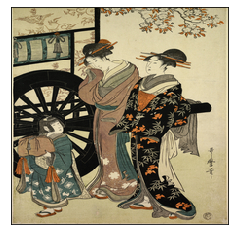

[t: 4  ==> pred: 6 ]
ID: 109   confidence: 0.7117891644056027


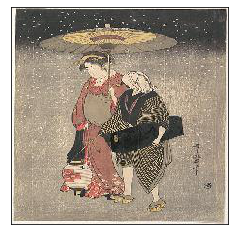

[t: 5  ==> pred: 1 ]
ID: 48   confidence: 0.39806989222191846


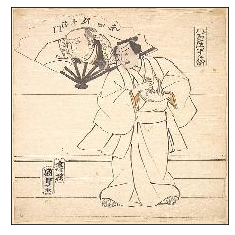

ID: 93   confidence: 0.563988148019864


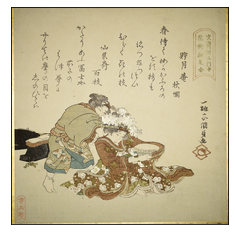

[t: 5  ==> pred: 2 ]
ID: 360   confidence: 0.2050966419852697


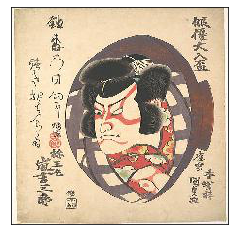

[t: 5  ==> pred: 4 ]
ID: 157   confidence: 0.8957021334745849


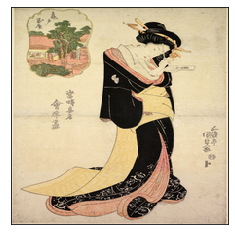

ID: 159   confidence: 0.6681000100305448


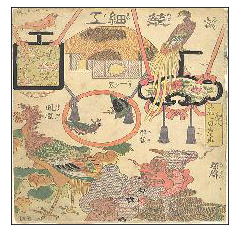

ID: 338   confidence: 0.7943991645096014


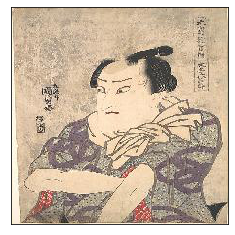

[t: 6  ==> pred: 1 ]
ID: 1   confidence: 0.351219418960122


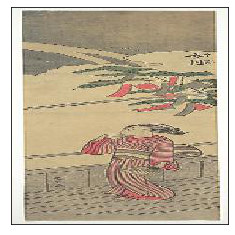

[t: 6  ==> pred: 2 ]
ID: 102   confidence: 0.5554908054809158


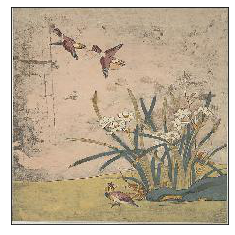

ID: 252   confidence: 0.7254026009916112


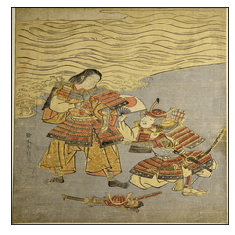

[t: 6  ==> pred: 8 ]
ID: 433   confidence: 0.5275726271076844


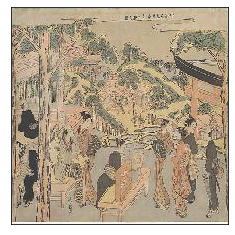

[t: 7  ==> pred: 0 ]
ID: 383   confidence: 0.44836424706647027


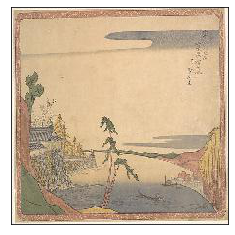

[t: 7  ==> pred: 1 ]
ID: 62   confidence: 0.5342590098914045


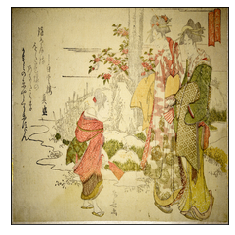

ID: 593   confidence: 0.4519296529201361


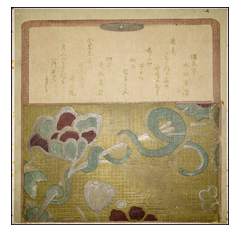

[t: 7  ==> pred: 3 ]
ID: 124   confidence: 0.5740751489423789


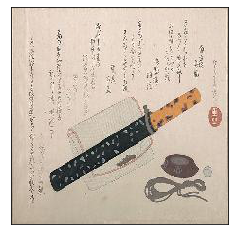

ID: 128   confidence: 0.7730384739832237


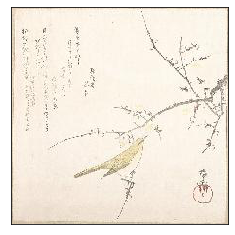

ID: 340   confidence: 0.6000231096091179


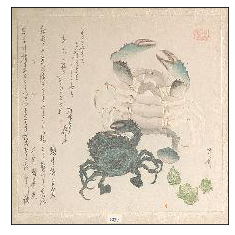

ID: 452   confidence: 0.5994964287831233


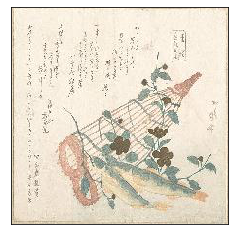

ID: 466   confidence: 0.523418943469341


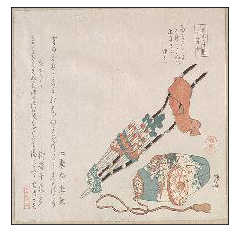

ID: 627   confidence: 0.5010987466185515


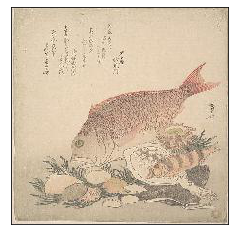

[t: 7  ==> pred: 4 ]
ID: 266   confidence: 0.2638245147581284


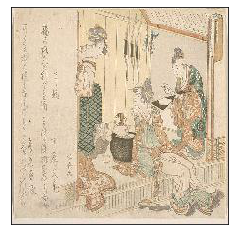

[t: 8  ==> pred: 4 ]
ID: 319   confidence: 0.2971578541283424


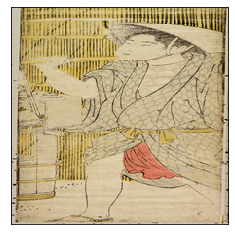

ID: 327   confidence: 0.7645069383657895


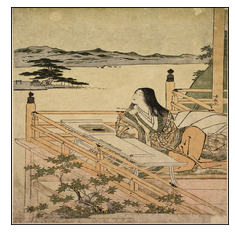

ID: 482   confidence: 0.6025298141802733


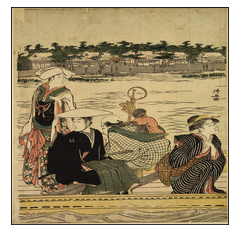

[t: 8  ==> pred: 6 ]
ID: 2   confidence: 0.4861536341217848


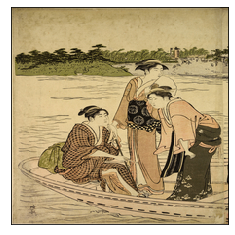

ID: 174   confidence: 0.3728108508512378


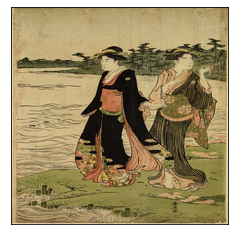

[t: 9  ==> pred: 0 ]
ID: 50   confidence: 0.527603397002587


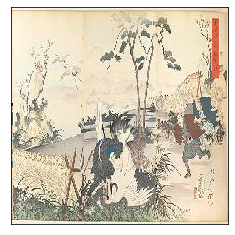

ID: 427   confidence: 0.7716937070855727


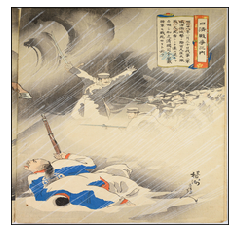

[t: 9  ==> pred: 4 ]
ID: 167   confidence: 0.2079728958555139


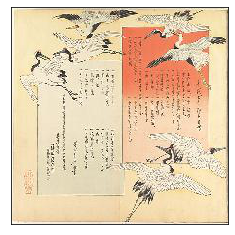

[t: 9  ==> pred: 5 ]
ID: 213   confidence: 0.30901612364687026


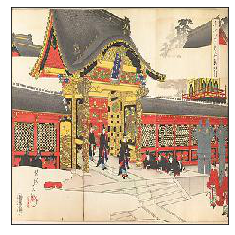

In [8]:
dataset = UkiyoeTrainDataset(
    train_images_path='data',
    train_labels_path='data',
    valid=True,
    transform=Compose([
        Resize(cons.IMAGE_SIZE,cons.IMAGE_SIZE),
    ],p=1),
    as_numpy=True)
miss_images = np.where(pred!=t)[0]
print('miss_images:',miss_images)
print('\n')
detictied=False
for label_t in range(cons.NUM_CLASSES):
    for label_pred in range(cons.NUM_CLASSES):
        for id in miss_images:
            if t[id]==label_t and pred[id]==label_pred:
                if not detictied:
                    print('[t:',label_t,' ==> pred:',label_pred,']')
                    detictied = True
                print('ID:',id,'  confidence:',confidence[id][pred[id]])    
                plt.xticks([])
                plt.yticks([])
                plt.imshow(dataset.__getitem__(id)[0])
                plt.show()
        detictied=False